In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_implicit_solvent.utils import remove_top_right_spines
%matplotlib inline

result = np.load('../bayes_implicit_solvent/data/elemental_types_nelder-mead_freesolv_n_config=50_gaussian_ll_traj.npz')
#result = np.load('../bayes_implicit_solvent/data/elemental_types_nelder-mead_freesolv_n_config=25_gaussian_ll_traj.npz')

In [2]:
traj = result['traj']

In [3]:
loss_traj = result['loss_traj']

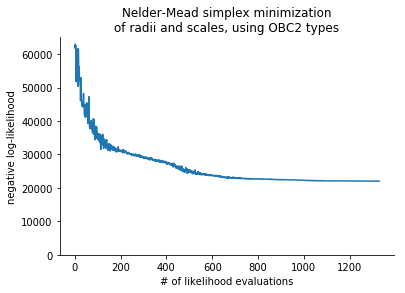

In [4]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(loss_traj)
plt.ylim(0,)
plt.xlabel('# of likelihood evaluations')
plt.ylabel('negative log-likelihood')

title = 'Nelder-Mead simplex minimization\nof radii and scales, using OBC2 types'
plt.title(title)

plt.savefig('nelder_mead_plots/log-likelihood.png', dpi=300)

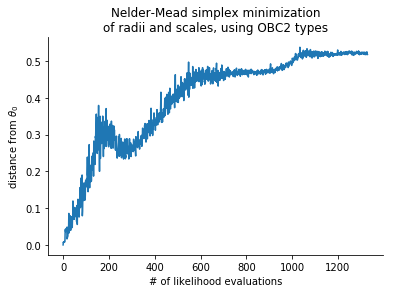

In [5]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(np.linalg.norm(traj - traj[0], axis=1))
plt.xlabel('# of likelihood evaluations')
plt.ylabel(r'distance from $\theta_0$')
plt.title(title)

plt.savefig('nelder_mead_plots/distance-from-start.png', dpi=300)

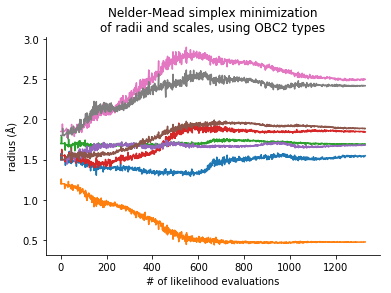

In [6]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

n = int(traj.shape[1] / 2)
plt.plot(traj[:, :n] * 10)

plt.xlabel('# of likelihood evaluations')
plt.ylabel('radius (Å)')
plt.title('Nelder-Mead simplex minimization')

plt.title(title)

plt.savefig('nelder_mead_plots/radii.png', dpi=300)

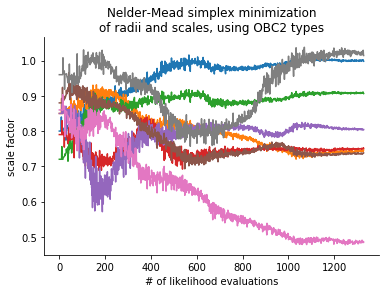

In [7]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

n = int(traj.shape[1] / 2)
plt.plot(traj[:, n:])

plt.xlabel('# of likelihood evaluations')
plt.ylabel('scale factor')
plt.title('Nelder-Mead simplex minimization')

plt.title(title)

plt.savefig('nelder_mead_plots/scales.png', dpi=300)

In [8]:
min(loss_traj)

22014.793616966785

In [9]:
from bayes_implicit_solvent.continuous_parameter_experiments import gradient_free
from bayes_implicit_solvent.continuous_parameter_experiments.gradient_free import extract_cid_key
from bayes_implicit_solvent.freesolv import cid_to_smiles
from bayes_implicit_solvent.molecule import Molecule

number of molecules being considered: 158


In [10]:
from pkg_resources import resource_filename
from glob import glob
path_to_vacuum_samples = resource_filename('bayes_implicit_solvent',
                                           'vacuum_samples/short_run/vacuum_samples_*.npy')
paths_to_samples = glob(path_to_vacuum_samples)
np.random.seed(0)
np.random.shuffle(paths_to_samples)
paths_to_samples = paths_to_samples#
train_paths_to_samples = paths_to_samples[::2]
test_paths_to_samples = paths_to_samples[1::2]

print('number of molecules being considered: {}'.format(len(paths_to_samples)))

cids = list(map(extract_cid_key, paths_to_samples))
train_cids = list(map(extract_cid_key, train_paths_to_samples))
test_cids = list(map(extract_cid_key, test_paths_to_samples))
print('first few CIDs', cids[:5])

mols = []

n_configuration_samples = 50

for path in paths_to_samples:
    cid = extract_cid_key(path)
    smiles = cid_to_smiles[cid]
    vacuum_samples = gradient_free.sample_path_to_unitted_snapshots(path)
    thinning = int(len(vacuum_samples) / n_configuration_samples)
    mol = Molecule(smiles, vacuum_samples=vacuum_samples[::thinning])
    mols.append(mol)
    
from bayes_implicit_solvent.gb_models.obc2_parameters import obc2_model

type_slices = [obc2_model.apply_to_molecule(mol.mol) for mol in mols]

def construct_arrays(theta):
    n = int(len(theta) / 2)
    radii, scales = theta[:n], theta[n:]

    parameterized_list = []
    for i in range(len(mols)):
        parameterized_list.append((radii[type_slices[i]], scales[type_slices[i]]))
    return parameterized_list

number of molecules being considered: 642
first few CIDs ['mobley_3187514', 'mobley_1363784', 'mobley_900088', 'mobley_9913368', 'mobley_766666']


In [11]:
from simtk import unit
from bayes_implicit_solvent.constants import beta
def unreduce(value):
    """Input value is in units of kB T, turn it into units of kilocalorie_per_mole"""
    return value / (beta * unit.kilocalorie_per_mole)

def make_predictions(theta):
    predictions = np.zeros(len(mols))
    parameterized_list = construct_arrays(theta)
    for i, mol in enumerate(mols):
        radii, scale_factors = parameterized_list[i]
        predictions[i] = mol.predict_solvation_free_energy(radii, scale_factors)[0]
    return unreduce(predictions)

In [12]:
%%time
initial_predictions = make_predictions(traj[0])

CPU times: user 3.73 s, sys: 9.95 ms, total: 3.74 s
Wall time: 3.74 s


In [13]:
%%time
optimized_predictions = make_predictions(traj[-1])

CPU times: user 3.69 s, sys: 23.2 ms, total: 3.71 s
Wall time: 3.71 s


In [14]:
mol = mols[0]
mol.experimental_value

-9.333559357658267

In [15]:
experimental_values = np.zeros(len(mols))
for i in range(len(mols)):
    experimental_values[i] = unreduce(mols[i].experimental_value)

In [16]:
sum((experimental_values >= -15) * (experimental_values <= 5))

631

In [17]:
mask = (experimental_values >= -15) * (experimental_values <= 5)
mask[:5]

array([ True,  True,  True,  True,  True])

In [18]:
len(experimental_values)

642

In [19]:
max(experimental_values)

3.4300000000000006

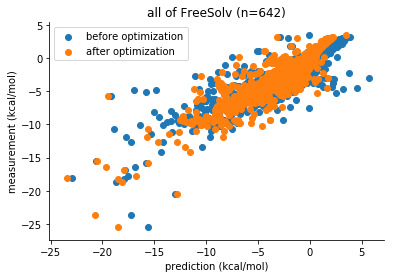

In [20]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.scatter(initial_predictions, experimental_values, label='before optimization')
plt.scatter(optimized_predictions, experimental_values, label='after optimization')
plt.legend()
plt.xlabel('prediction (kcal/mol)')
plt.ylabel('measurement (kcal/mol)')

all_freesolv_descr = 'all of FreeSolv (n={})'.format(len(experimental_values))
plt.title(all_freesolv_descr)


plt.savefig('nelder_mead_plots/scatter-all-freesolv.png', dpi=300)

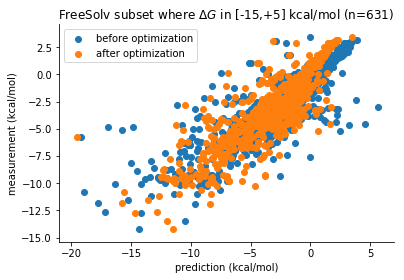

In [21]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.scatter(initial_predictions[mask], experimental_values[mask], label='before optimization')
plt.scatter(optimized_predictions[mask], experimental_values[mask], label='after optimization')

freesolv_subset_descr = 'FreeSolv subset where $\Delta G$ in [-15,+5] kcal/mol (n={})'.format(sum(mask))
plt.title(freesolv_subset_descr)
plt.legend()
plt.xlabel('prediction (kcal/mol)')
plt.ylabel('measurement (kcal/mol)')

plt.savefig('nelder_mead_plots/scatter-freesolv-subset.png', dpi=300)

In [22]:
np.sqrt(np.mean((initial_predictions - experimental_values)**2)), np.sqrt(np.mean((optimized_predictions - experimental_values)**2))

(2.5343387545006664, 2.025046116864035)

In [23]:
np.sqrt(np.mean((initial_predictions[mask] - experimental_values[mask])**2)), np.sqrt(np.mean((optimized_predictions[mask] - experimental_values[mask])**2))

(2.4792677492589994, 1.970736054322448)

In [24]:
from tqdm import tqdm
thinning = 10

prediction_traj = []

for snapshot in tqdm(traj[::thinning]):
    prediction_traj.append(make_predictions(snapshot))

100%|██████████| 133/133 [08:59<00:00,  3.97s/it]


In [25]:
x = np.arange(len(traj))[::thinning]

In [26]:
rmses = []
masked_rmses = []
for predictions in prediction_traj:
    rmses.append(np.sqrt(np.mean((predictions - experimental_values)**2)))
    masked_rmses.append(np.sqrt(np.mean((predictions[mask] - experimental_values[mask])**2)))

In [27]:
min(rmses), min(masked_rmses)

(1.982894443019273, 1.929896943090024)

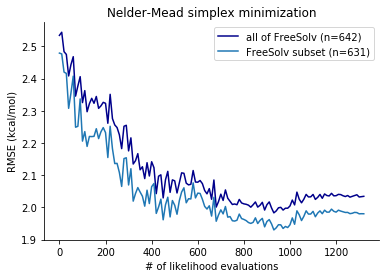

In [28]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(x, rmses, color='darkblue', label=all_freesolv_descr)
plt.plot(x, masked_rmses, label='FreeSolv subset (n={})'.format(sum(mask)))
#plt.ylim(0,)
plt.xlabel('# of likelihood evaluations')
plt.ylabel('RMSE (kcal/mol)')
plt.title('Nelder-Mead simplex minimization')
plt.legend()

plt.savefig('nelder_mead_plots/rmse-trace.png', dpi=300)